In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

# Load Dataset, Inspect Datatypes and check if there are any missing values


In [2]:
# load the dataset
df = pd.read_excel("Data_Scientist_-_Case_Dataset.xlsx",sheet_name=0,sep=",")
# check basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 1 columns):
 #   Column                                                                                                                      Non-Null Count  Dtype 
---  ------                                                                                                                      --------------  ----- 
 0   customer_id,converted,customer_segment,gender,age,related_customers,family_size,initial_fee_level,credit_account_id,branch  891 non-null    object
dtypes: object(1)
memory usage: 7.1+ KB


In [3]:
df.head()

,"customer_id,converted,customer_segment,gender,age,related_customers,family_size,initial_fee_level,credit_account_id,branch"
0,"15001,0,13,male,22.0,1,0,14.5,9b2d5b4678781e53..."
1,"15002,1,11,female,38.0,1,0,142.5666,afa2dc179e..."
2,"15003,1,13,female,26.0,0,0,15.85,9b2d5b4678781..."
3,"15004,1,11,female,35.0,1,0,106.2,abefcf257b5d2..."
4,"15005,0,13,male,35.0,0,0,16.1,9b2d5b4678781e53..."


In [4]:
cols=df.columns[0].split(",")

new_rows=[]
for i, row in df.iterrows():
    for j, column in row.iteritems():
        new_rows.append(column.split(","))
        
dataset=pd.DataFrame(new_rows,columns=cols)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        891 non-null    object
 1   converted          891 non-null    object
 2   customer_segment   891 non-null    object
 3   gender             891 non-null    object
 4   age                891 non-null    object
 5   related_customers  891 non-null    object
 6   family_size        891 non-null    object
 7   initial_fee_level  891 non-null    object
 8   credit_account_id  891 non-null    object
 9   branch             891 non-null    object
dtypes: object(10)
memory usage: 69.7+ KB


In [5]:
# find missing values 
dataset.isnull().sum()

customer_id          0
converted            0
customer_segment     0
gender               0
age                  0
related_customers    0
family_size          0
initial_fee_level    0
credit_account_id    0
branch               0
dtype: int64

### All data types are 'Object' type

In [6]:
# convert the datatypes to correct format, i.e. Numeric where needed to process data properly
dataset['converted']=pd.to_numeric(dataset['converted'], errors='coerce')
dataset['age']=pd.to_numeric(dataset['age'], errors='coerce')
dataset['customer_segment']=pd.to_numeric(dataset['customer_segment'], errors='coerce')
dataset['family_size']=pd.to_numeric(dataset['family_size'], errors='coerce')
dataset['initial_fee_level']=pd.to_numeric(dataset['initial_fee_level'], errors='coerce')
dataset['related_customers']=pd.to_numeric(dataset['related_customers'], errors='coerce')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        891 non-null    object 
 1   converted          891 non-null    int64  
 2   customer_segment   891 non-null    int64  
 3   gender             891 non-null    object 
 4   age                714 non-null    float64
 5   related_customers  891 non-null    int64  
 6   family_size        891 non-null    int64  
 7   initial_fee_level  891 non-null    float64
 8   credit_account_id  891 non-null    object 
 9   branch             891 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 69.7+ KB


## Handle missing and wrong datapoints

In [7]:
# find missing values again after proper formatting of dataframe
dataset.isnull().sum()


customer_id            0
converted              0
customer_segment       0
gender                 0
age                  177
related_customers      0
family_size            0
initial_fee_level      0
credit_account_id      0
branch                 0
dtype: int64

# Handling the NaNs in the dataframe

In [8]:
# replace NaNs by 0 in 'age' column
# Not deleting the datapoints to avoid loss of information with regards to other poytential features, since removing the rows with null values removes the whole datapoint
dataset['age'] = dataset['age'].replace(np.nan, 0)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        891 non-null    object 
 1   converted          891 non-null    int64  
 2   customer_segment   891 non-null    int64  
 3   gender             891 non-null    object 
 4   age                891 non-null    float64
 5   related_customers  891 non-null    int64  
 6   family_size        891 non-null    int64  
 7   initial_fee_level  891 non-null    float64
 8   credit_account_id  891 non-null    object 
 9   branch             891 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 69.7+ KB


In [9]:
dataset.groupby('age')['age'].count()

age
0.00     177
0.42       1
0.67       1
0.75       2
0.83       2
        ... 
70.00      2
70.50      1
71.00      2
74.00      1
80.00      1
Name: age, Length: 89, dtype: int64

In [10]:
# correcting the wrong entries and rounding up the numbers
def correct_age(row):
    if row['age']<1:
        return row['age']*100
    else:
        return round(row['age'])

dataset['age']=dataset.apply(correct_age,axis=1)

In [11]:
# binning the age into groups by decade
dataset['age_by_decade'] = pd.cut(x=dataset['age'], bins=[0,10,20, 29, 39, 49,59,69,79,89], labels=['10s','20s', '30s', '40s','50s','60s','70s','80s','90s'])

# Handling categorical features

In [12]:
# checking values for column 'gender'
dataset['gender'].unique()

array(['male', 'female'], dtype=object)

In [13]:
# Encoding column 'gender' based on current dataset. And considering other category encoded as 3
def change_val_gender(row):
    if row['gender']=='female':
        return 1
    elif row['gender']=='male':
        return 2
    else:
        return 3

dataset['gender_enc']=dataset.apply(change_val_gender,axis=1)

In [14]:
# checking values for column 'gender'
dataset['branch'].unique()

array(['Helsinki', 'Tampere', 'Turku', ''], dtype=object)

In [15]:
# Encoding column 'branch' based on current dataset. And considering empty category encoded as 4
def change_val_gender(row):
    if row['branch']=='Helsinki':
        return 1
    elif row['branch']=='Tampere':
        return 2
    elif row['branch']=='Turku':
        return 3
    else:
        return 4

dataset['branch_enc']=dataset.apply(change_val_gender,axis=1)

In [16]:
# column 'credit_account_id'
# if customer has none it is shown as 9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6c9bc9d493a23be9de0. 
# So using this information to create new column whether the customer has credit account or not
def check_credit_account(row):
    if "9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6c9bc9d493a23be9de0" in row['credit_account_id'] :
        return 0
    else:
        return 1
    
dataset['has_credit_account']=dataset.apply(check_credit_account,axis=1)

In [17]:
dataset.head()

,customer_id,converted,customer_segment,gender,age,related_customers,family_size,initial_fee_level,credit_account_id,branch,age_by_decade,gender_enc,branch_enc,has_credit_account
0,15001,0,13,male,22.0,1,0,14.5000,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Helsinki,30s,2,1,0
1,15002,1,11,female,38.0,1,0,142.5666,afa2dc179e46e8456ffff9016f91396e9c6adf1fe20d17...,Tampere,40s,1,2,1
2,15003,1,13,female,26.0,0,0,15.8500,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Helsinki,30s,1,1,0
3,15004,1,11,female,35.0,1,0,106.2000,abefcf257b5d2ff2816a68ec7c84ec8c11e0e0dc4f3425...,Helsinki,40s,1,1,1
4,15005,0,13,male,35.0,0,0,16.1000,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Helsinki,40s,2,1,0


# Find correlations using Pearson Correlation Coefficient

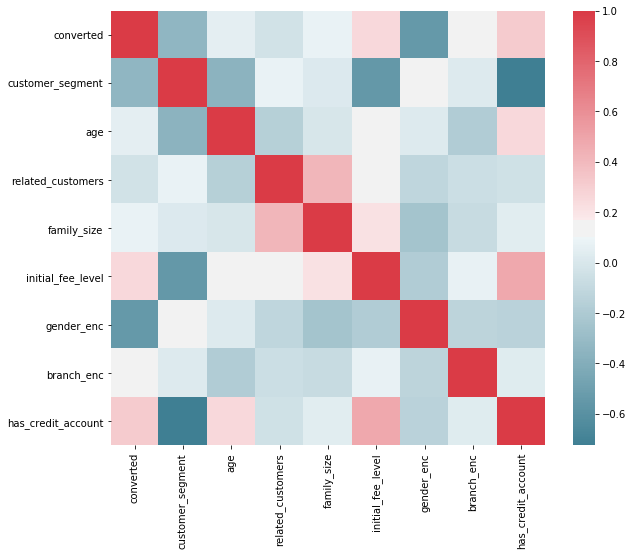

In [18]:
# run correlation matrix and plot
f, ax = plt.subplots(figsize=(10, 8))
corr = dataset.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [19]:
display(corr)

,converted,customer_segment,age,related_customers,family_size,initial_fee_level,gender_enc,branch_enc,has_credit_account
converted,1.000000,-0.338481,0.050745,-0.035322,0.081629,0.257307,-0.543351,0.118026,0.316912
customer_segment,-0.338481,1.000000,-0.356485,0.083081,0.018443,-0.549500,0.131900,0.028566,-0.725541
age,0.050745,-0.356485,1.000000,-0.164569,-0.009732,0.138869,0.028436,-0.185097,0.258532
related_customers,-0.035322,0.083081,-0.164569,1.000000,0.414838,0.159651,-0.114631,-0.063794,-0.040460
family_size,0.081629,0.018443,-0.009732,0.414838,1.000000,0.216225,-0.245489,-0.082144,0.036987
initial_fee_level,0.257307,-0.549500,0.138869,0.159651,0.216225,1.000000,-0.182333,0.071010,0.482075
gender_enc,-0.543351,0.131900,0.028436,-0.114631,-0.245489,-0.182333,1.000000,-0.128526,-0.140391
branch_enc,0.118026,0.028566,-0.185097,-0.063794,-0.082144,0.071010,-0.128526,1.000000,0.032614
has_credit_account,0.316912,-0.725541,0.258532,-0.040460,0.036987,0.482075,-0.140391,0.032614,1.000000


# (chi²) statistical test for best features selection

In [20]:
# Using the chi-squared (chi²) statistical test for non-negative features to select 5 best features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = dataset[["age","initial_fee_level","has_credit_account","gender_enc","customer_segment","family_size","related_customers","branch_enc"]
           ]
y = dataset["converted"]

# apply SelectKBest class to extract top 5 best features
bestfeatures = SelectKBest(score_func=chi2, k=5)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
# concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                Specs        Score
1   initial_fee_level  9036.638181
2  has_credit_account    68.997412
3          gender_enc    36.436861
0                 age    30.708536
5         family_size    10.097499
4    customer_segment     5.790754
7          branch_enc     3.800456
6   related_customers     2.581865


# Using visualizations for some features to observe correlations

## Gender and Customers converted

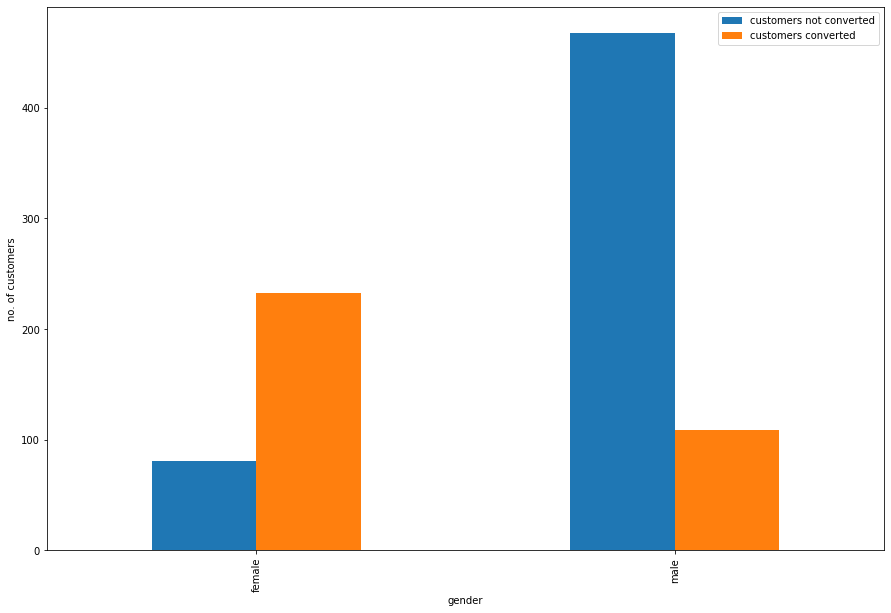

In [21]:
gender_patterns=dataset.groupby(['gender','converted'])['customer_id'].count()
gender_patterns_df = pd.DataFrame(gender_patterns.unstack(level = 1))
gender_patterns_df.plot(kind='bar',figsize=(15,10))
plt.legend(['customers not converted','customers converted'])
plt.ylabel('no. of customers')

plt.show()

## Initial fee level and customers converted

In [22]:
# binning initial fee level among different fee groups

## Assumption : There are few rows where values for initial_fee_level is 0. 
## It is assumed that it probably has given as free trial to customers as promotional offer or new customer benefits.

dataset['initial_fee_group'] = pd.cut(x=dataset['initial_fee_level'], bins=[-1,0,20,50,100,200,500,1000], labels=['free trial','less than 20','20-50','50-100','100-200','200-500','500-1000'])

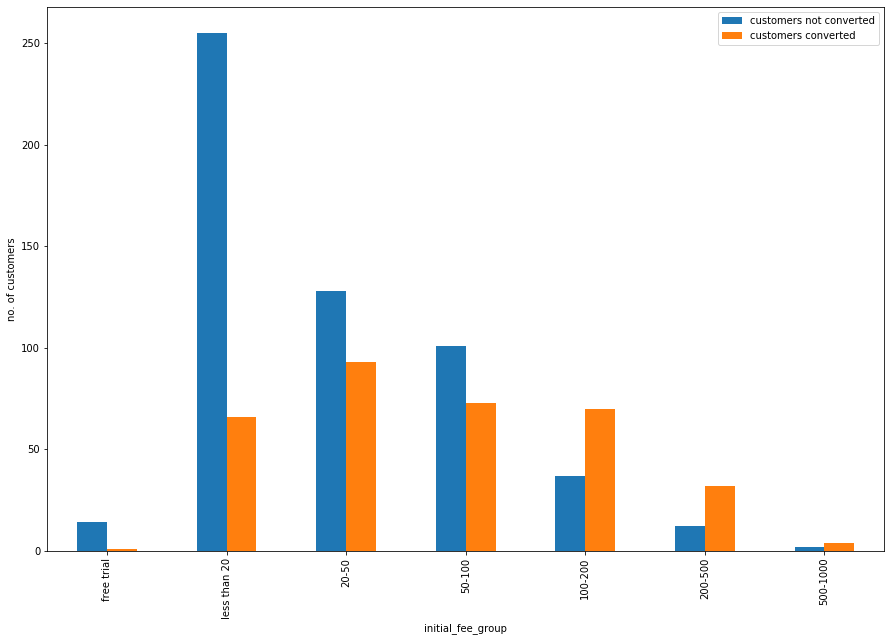

In [23]:
initial_fee_patterns=dataset.groupby(['initial_fee_group','converted'])['customer_id'].count()
initial_fee_patterns_df = pd.DataFrame(initial_fee_patterns.unstack(level = 1))
initial_fee_patterns_df.plot(kind='bar',figsize=(15,10))
plt.legend(['customers not converted','customers converted'])
plt.ylabel('no. of customers')

plt.show()

# Relationship between Customers converted and customer_segment

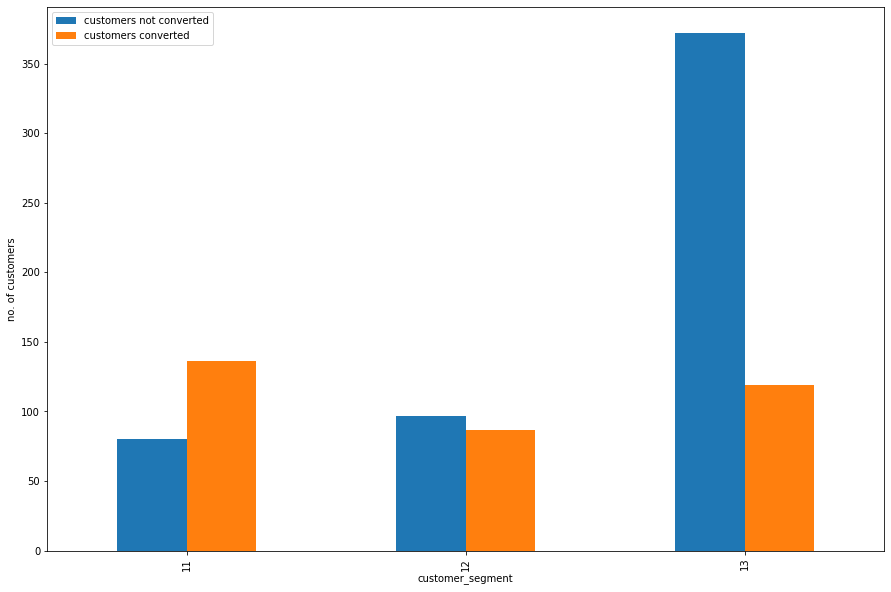

In [24]:
segment_patterns=dataset.groupby(['customer_segment','converted'])['customer_id'].count()
segment_patterns_df = pd.DataFrame(segment_patterns.unstack(level = 1))
segment_patterns_df.plot(kind='bar',figsize=(15,10))
plt.legend(['customers not converted','customers converted'])
plt.ylabel('no. of customers')

plt.show()

## Relationship among credit account, age and converted

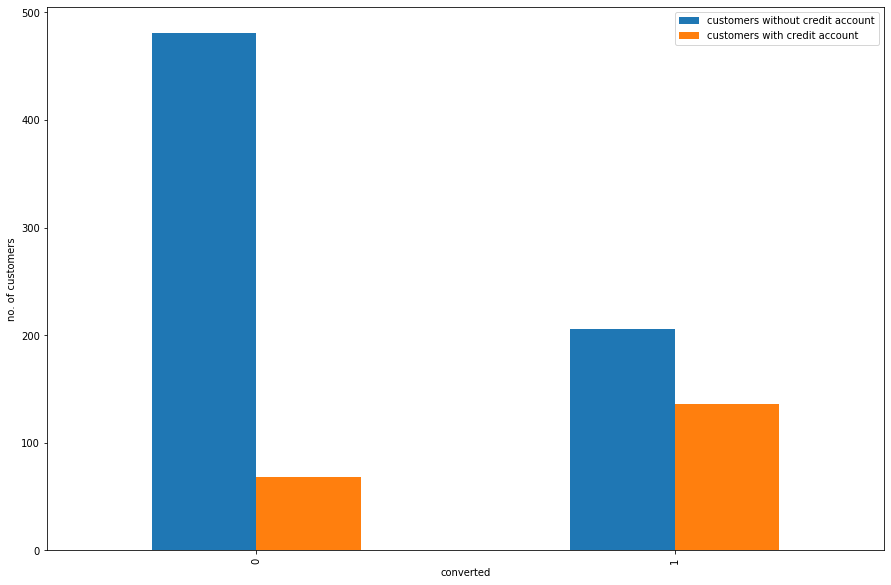

In [25]:
credit_patterns=dataset.groupby(['converted','has_credit_account'])['customer_id'].count()
credit_patterns_df = pd.DataFrame(credit_patterns.unstack(level = 1))
credit_patterns_df.plot(kind='bar',figsize=(15,10))
plt.legend(['customers without credit account','customers with credit account'])
plt.ylabel('no. of customers')

plt.show()

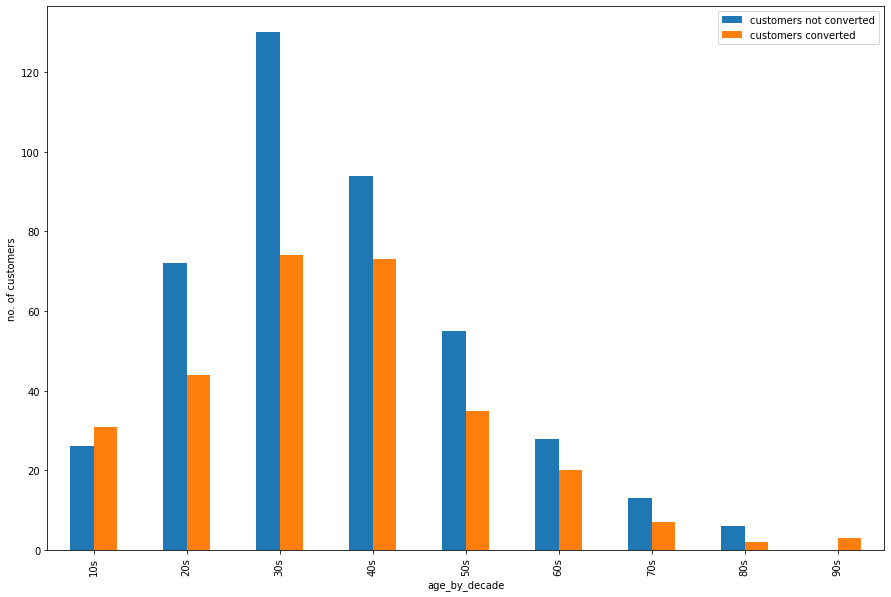

In [26]:
age_patterns=dataset.groupby(['age_by_decade','converted'])['customer_id'].count()
age_patterns_df = pd.DataFrame(age_patterns.unstack(level = 1))
age_patterns_df.plot(kind='bar',figsize=(15,10))
plt.legend(['customers not converted','customers converted'])
plt.ylabel('no. of customers')

plt.show()

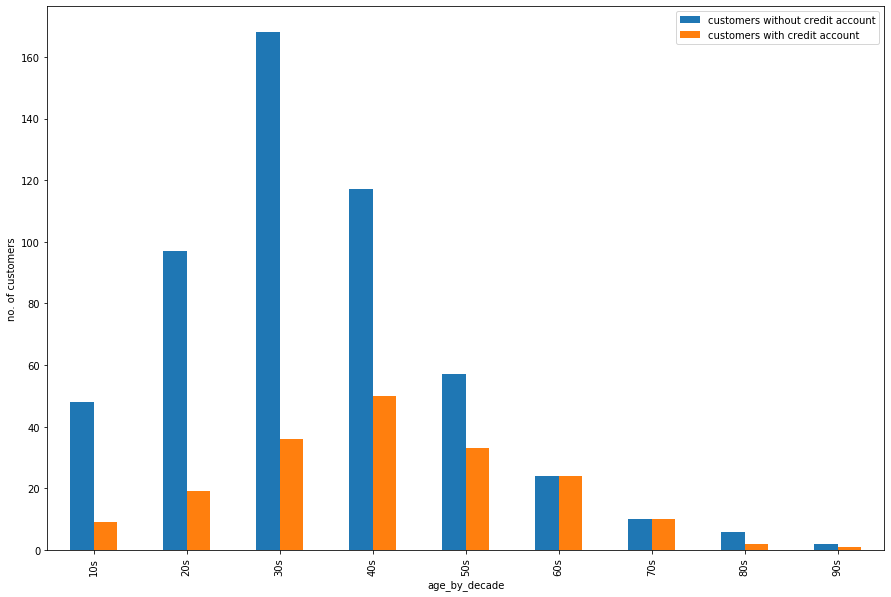

In [27]:
age_credit_patterns=dataset.groupby(['age_by_decade','has_credit_account'])['customer_id'].count()
age_credit_patterns_df = pd.DataFrame(age_credit_patterns.unstack(level = 1))
age_credit_patterns_df.plot(kind='bar',figsize=(15,10))
plt.legend(['customers without credit account','customers with credit account'])
plt.ylabel('no. of customers')

plt.show()

## Family size, related customers and converted

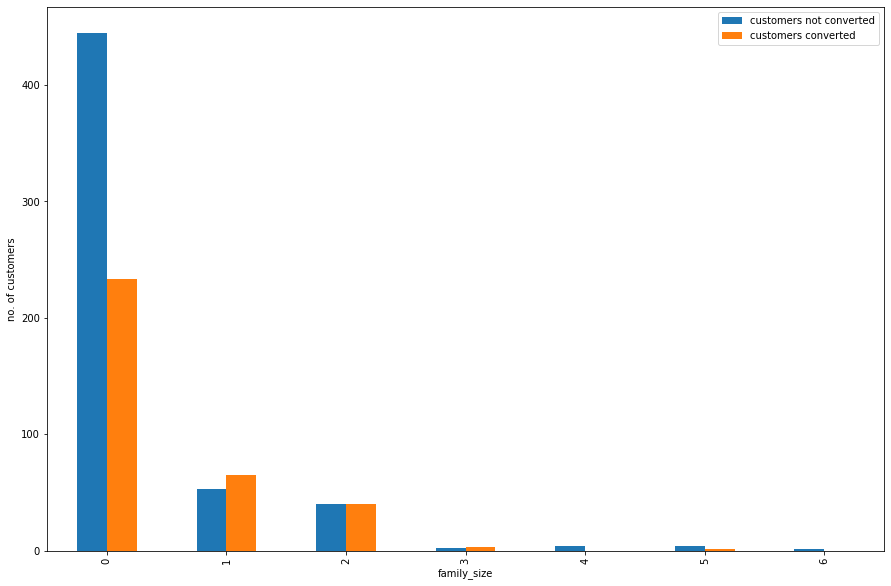

In [28]:
family_size_patterns=dataset.groupby(['family_size','converted'])['customer_id'].count()
family_size_patterns_df = pd.DataFrame(family_size_patterns.unstack(level = 1))
family_size_patterns_df.plot(kind='bar',figsize=(15,10))
plt.legend(['customers not converted','customers converted'])
plt.ylabel('no. of customers')

plt.show()

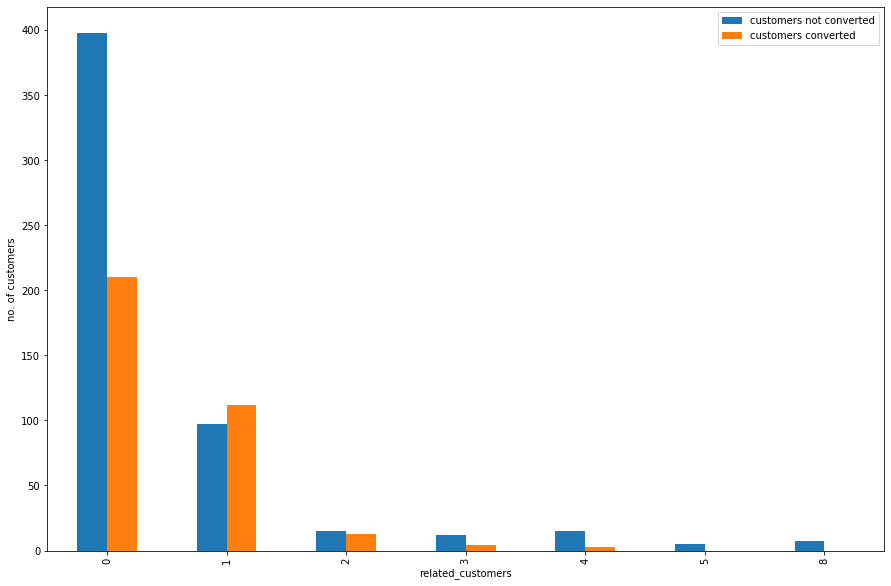

In [29]:
related_customers_patterns=dataset.groupby(['related_customers','converted'])['customer_id'].count()
related_customers_patterns_df = pd.DataFrame(related_customers_patterns.unstack(level = 1))
related_customers_patterns_df.plot(kind='bar',figsize=(15,10))
plt.legend(['customers not converted','customers converted'])
plt.ylabel('no. of customers')

plt.show()